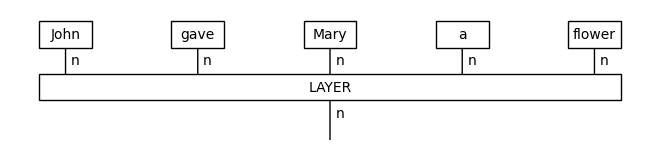

In [1]:
import warnings
warnings.filterwarnings('ignore')

from lambeq import AtomicType, Reader
from lambeq.backend.grammar import Box, Id, Word

N = AtomicType.NOUN

class CombReader(Reader):
    def sentence2diagram(self, sentence):
        words = Id().tensor(*[Word(w, N) for w in sentence.split()])
        layer = Box('LAYER', words.cod, N)
        return words >> layer

diagram = CombReader().sentence2diagram('John gave Mary a flower')
diagram.draw()

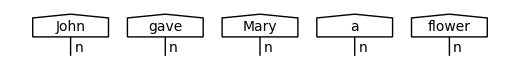

In [2]:
Id().tensor(*[Word(w, N) for w in ['John', 'gave', 'Mary', 'a', 'flower']]).draw(figsize=(5,1))

In [3]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')
d = parser.sentence2diagram('The food is fresh')

In [4]:
from lambeq import AtomicType, SimpleRewriteRule

N = AtomicType.NOUN
S = AtomicType.SENTENCE
adj = N @ N.l

NOT = Box('NOT', S, S)

negation_rewrite = SimpleRewriteRule(
    cod=N.r @ S @ S.l @ N,
    template=SimpleRewriteRule.placeholder(N.r @ S @ S.l @ N) >> Id(N.r) @ NOT @ Id(S.l @ N),
    words=['is', 'was', 'has', 'have'])

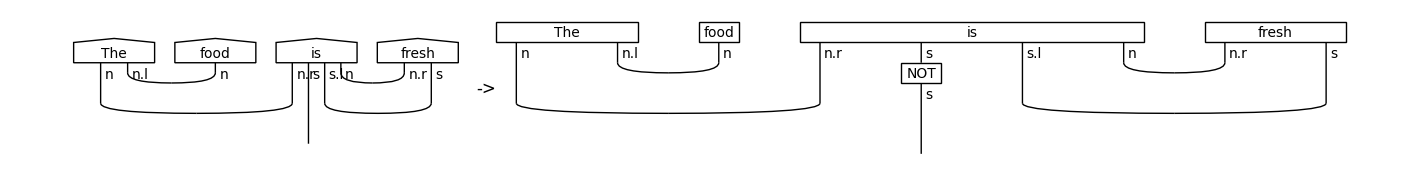

In [5]:
from lambeq import Rewriter
from lambeq.backend import draw_equation

not_d = Rewriter([negation_rewrite])(d)
draw_equation(d, not_d, symbol='->', figsize=(14, 4))

In [6]:
from lambeq import RewriteRule

class PastRewriteRule(RewriteRule):
    mapping = {
        'is': 'was',
        'are': 'were',
        'has': 'had'
    }
    def matches(self, box):
        return box.name in self.mapping
    
    def rewrite(self, box):
        new_name = self.mapping[box.name]
        return type(box)(name=new_name, cod=box.cod)

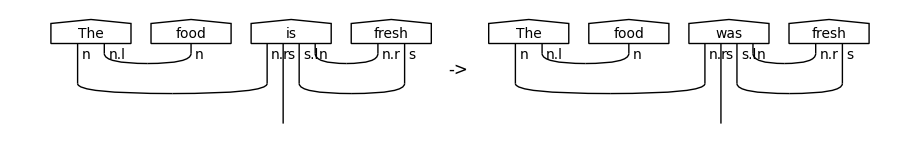

In [7]:
past_d = Rewriter([PastRewriteRule()])(d)
draw_equation(d, past_d, symbol='->', figsize=(9, 2))

In [8]:
d = parser.sentence2diagram('We will go')

In [9]:
from lambeq.backend.quantum import CX, Id, Ry

from lambeq import CircuitAnsatz
    
def real_ansatz_circuit(n_qubits, params):

    circuit = Id(n_qubits)
    n_layers = params.shape[0] - 1

    for i in range(n_layers):
        syms = params[i]

        # adds a layer of Y rotations
        circuit >>= Id().tensor(*[Ry(sym) for sym in syms])

        # adds a ladder of CNOTs
        for j in range(n_qubits - 1):
            circuit >>= Id(j) @ CX @ Id(n_qubits - j - 2)

    # adds a final layer of Y rotations
    circuit >>= Id().tensor(*[Ry(sym) for sym in params[-1]])

    return circuit


class RealAnsatz(CircuitAnsatz):
    def __init__(self, ob_map, n_layers, n_single_qubit_params = 1, discard = False):

        super().__init__(ob_map,
                         n_layers,
                         n_single_qubit_params,
                         real_ansatz_circuit,
                         discard,
                         [Ry, ])

    def params_shape(self, n_qubits):
        return (self.n_layers + 1, n_qubits)

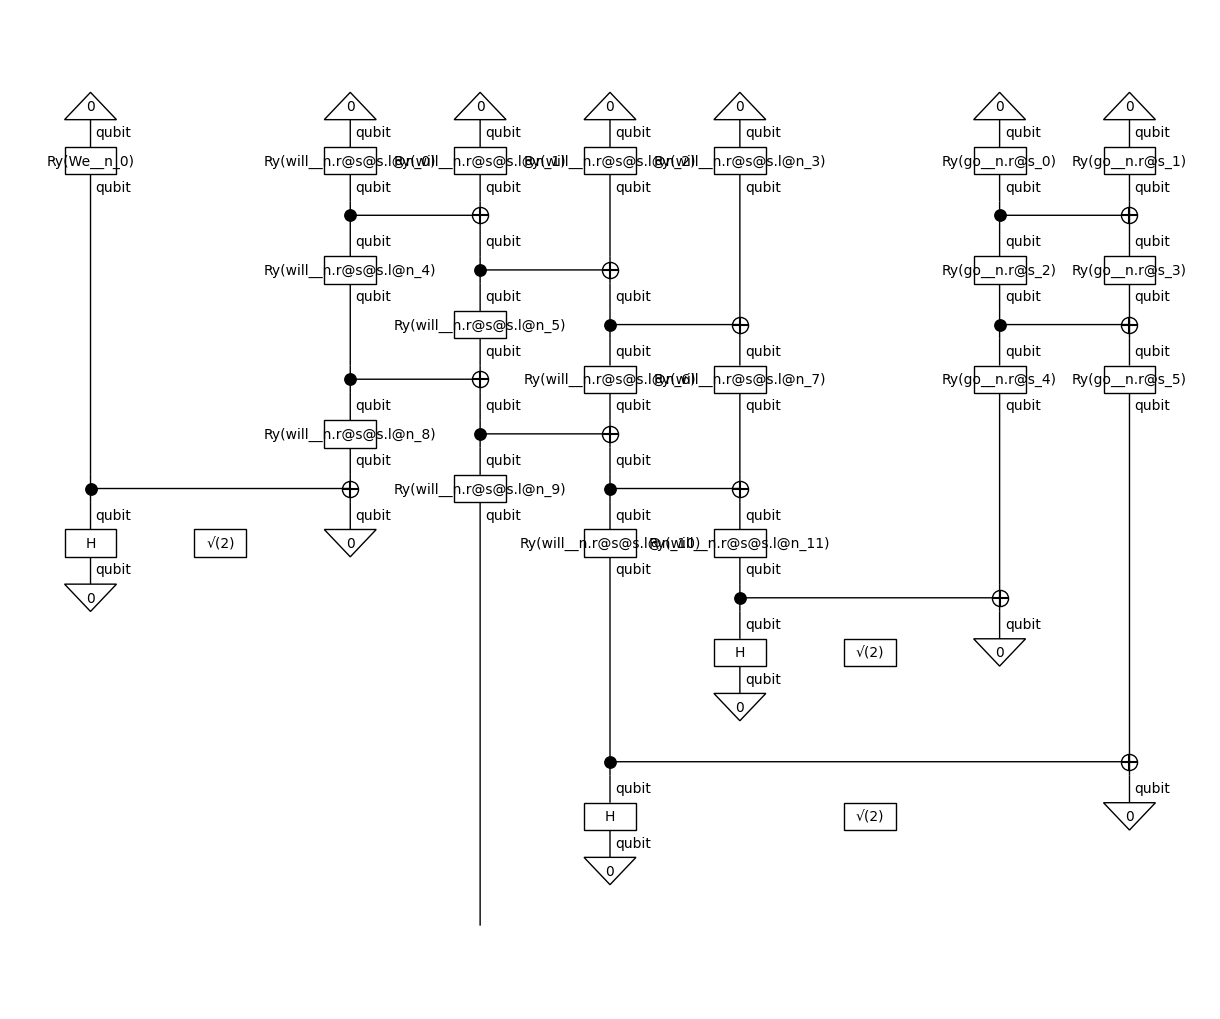

In [10]:
real_d = RealAnsatz({N: 1, S: 1}, n_layers=2)(d)
real_d.draw(figsize=(12, 10))

In [11]:
from lambeq import TensorAnsatz, Symbol
from lambeq.backend import tensor
import math

class PositiveAnsatz(TensorAnsatz):

    def _ar(self, functor, box):
        # step 1: obtain label
        name = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = functor(box.dom), functor(box.cod)

        # step 3: construct and return ansatz
        syms = Symbol(name, math.prod(dom.dim), math.prod(cod.dim))

        return tensor.Box(box.name, dom, cod, syms ** 2)

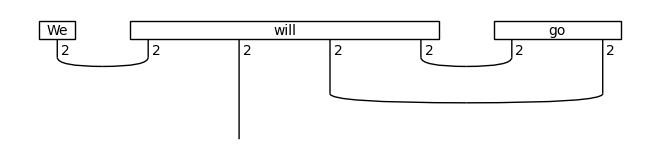

In [12]:
from lambeq.backend.tensor import Dim

ansatz = PositiveAnsatz({N: Dim(2), S: Dim(2)})
positive_d = ansatz(d)
positive_d.draw()

In [13]:
import numpy as np
from sympy import default_sort_key


syms = sorted(positive_d.free_symbols, key=default_sort_key)
sym_dict = {k: -np.ones(k.size) for k in syms}
subbed_diagram = positive_d.lambdify(*syms)(*sym_dict.values())

subbed_diagram.eval()

array([8., 8.])